## Dataset Preparation

download happy & not happy dog images from Google Image

In [1]:
import os

current_path = os.getcwd()
data_path = os.path.join(current_path, 'convOut')

start downloading dog images to gather datasets with the google_img.py python script

search query: happy dog & sad dog

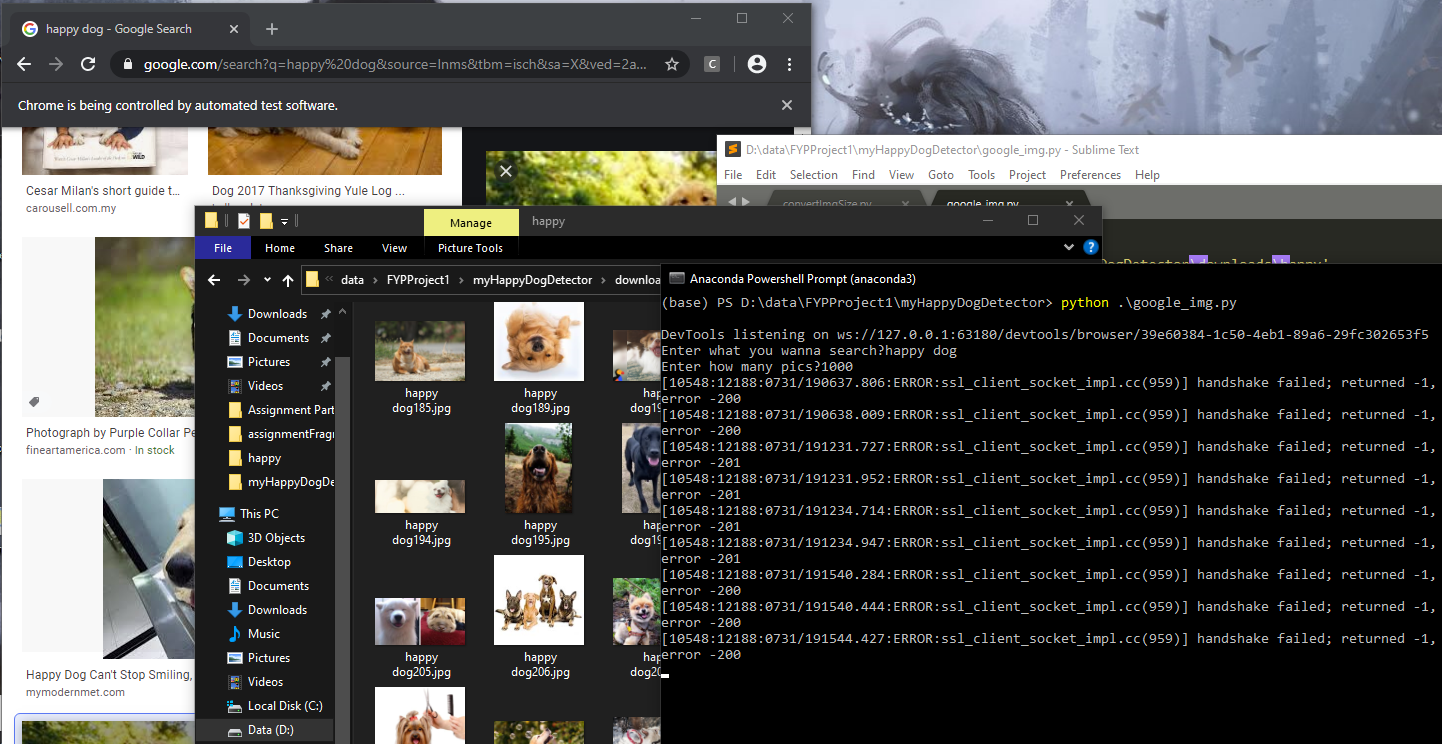

manually remove those images in the directory that are not related to the particular category

# Processing dataset 

# Resize image

resize each image to 224x224 using convertImgSize.py python script

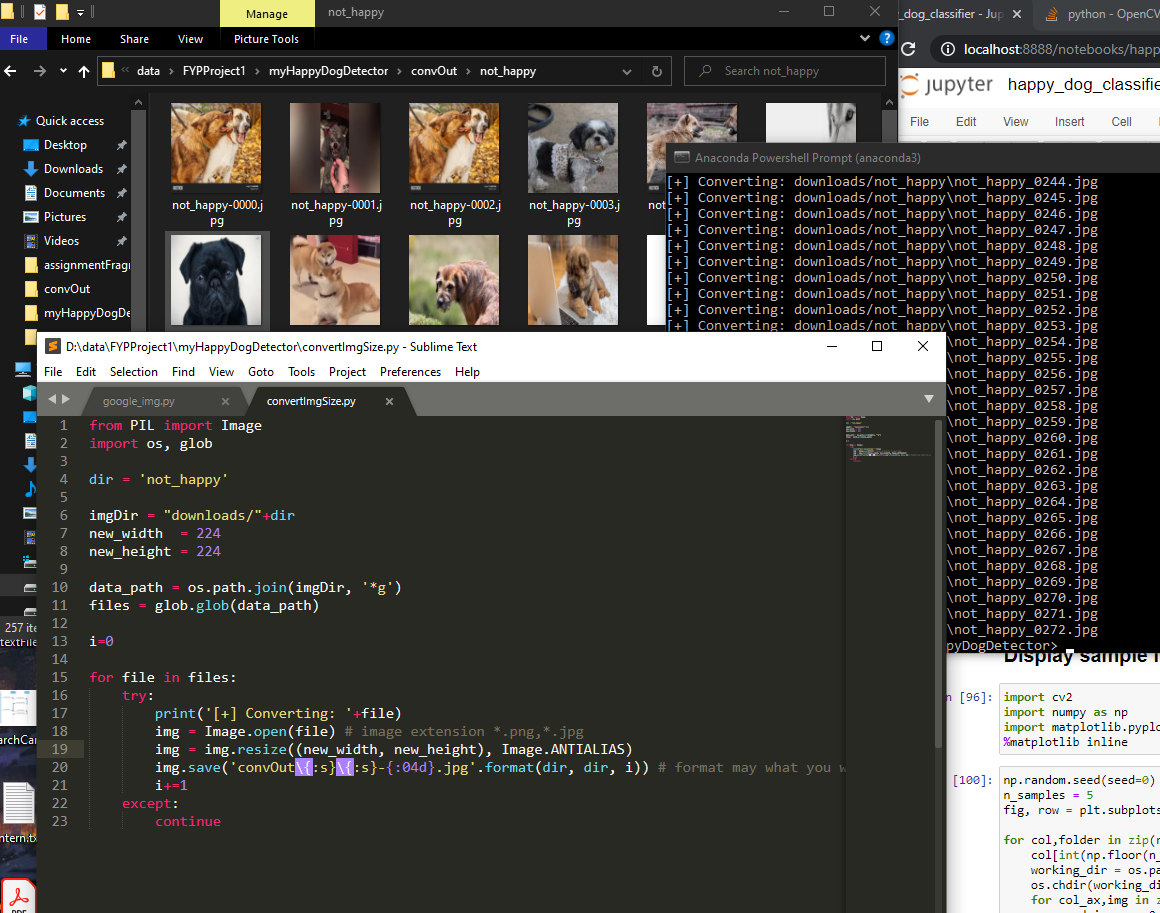

## renaming files

When we retrieve images from Google Image each image will have their unique name, so rename those image dataset to equal format.

In [2]:
data_folders = os.listdir(data_path)
for folder in data_folders:
    working_dir = os.path.join(data_path,folder)
    os.chdir(working_dir)
    current_list = os.listdir(os.getcwd())
    for i in range(len(os.listdir(working_dir))):
        original_name = current_list[i]
        new_name = "".join(folder.split()) + '_{:04d}'.format(i+1) + os.path.splitext(original_name)[-1]
        if not os.path.exists(new_name):
            os.rename(original_name,new_name)
os.chdir(current_path)

## Display sample images

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

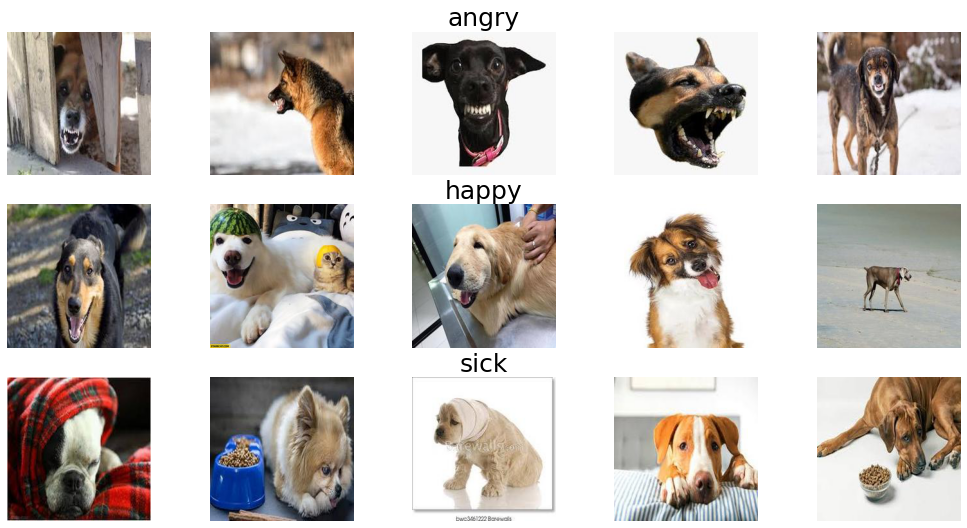

In [4]:
np.random.seed(seed=0)
n_samples = 5
fig, row = plt.subplots(3, n_samples, figsize = (4*n_samples, 3*3))

for col,folder in zip(row,data_folders):
    col[int(np.floor(n_samples/2))].set_title(folder,fontsize=25)
    working_dir = os.path.join(data_path,folder)
    os.chdir(working_dir)
    for col_ax,img in zip(col,np.random.choice(os.listdir(os.getcwd()),n_samples,replace=False)):
        rand_img = cv2.imread(img)
        rand_img = cv2.cvtColor(rand_img,cv2.COLOR_BGR2RGB)
        col_ax.imshow(rand_img)
        col_ax.axis('off')
plt.subplots_adjust(left=0.2, wspace=0.02)
os.chdir(current_path)

# Load & pre-processing

In [5]:
%%time
img_rows = 224
img_cols = 224
img_list = []
label_list = []
labels = dict([('happy',0),('angry',1),('sick',2)])
for folder in data_folders:
    working_dir = os.path.join(data_path,folder)
    os.chdir(working_dir)
    current_list = os.listdir(os.getcwd())
    for img in current_list:
        img_in = cv2.imread(img)    
        img_in = cv2.cvtColor(img_in,cv2.COLOR_BGR2RGB)    
        img_in = cv2.resize(img_in,(img_rows,img_cols),cv2.INTER_AREA)
        img_list.append(img_in)
        label_list.append(labels[folder])
os.chdir(current_path)

Wall time: 8.28 s


# normalization

In [6]:
img_data = np.array(img_list).astype(np.float32)
img_label = np.array(label_list)
img_data /= np.max(img_data)

# Splitting
splitting dataset into training, validation & testing

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
X_shuffled, y_shuffled = shuffle(img_data,img_label,random_state=0)

X_train,X_valid_test,y_train,y_valid_test = train_test_split(X_shuffled,y_shuffled,test_size=0.2,random_state=0,stratify=y_shuffled)
X_valid,X_test,y_valid,y_test = train_test_split(X_valid_test,y_valid_test,test_size=0.5,random_state=0,stratify=y_valid_test)
print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_valid shape: {}'.format(X_valid.shape))
print('y_valid shape: {}'.format(y_valid.shape))
print('X_test shape: {}'.format(X_test.shape))
print('y_test shape: {}'.format(y_test.shape))

X_train shape: (636, 224, 224, 3)
y_train shape: (636,)
X_valid shape: (80, 224, 224, 3)
y_valid shape: (80,)
X_test shape: (80, 224, 224, 3)
y_test shape: (80,)


# Building Model

import modules & params

In [9]:
from keras import initializers
from keras.models import Model,Sequential
from keras.layers import Input,Dense,Activation,BatchNormalization,Flatten,Conv2D,MaxPooling2D,GlobalAveragePooling2D,Dropout,Add
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from tensorflow import Tensor

In [10]:
%load_ext autoreload
%autoreload 2
import helper_module as hm

In [11]:
def identity_block(n_f,x):
    shortcut = x
    x = Conv2D(n_f,(3,3),strides=(1,1),padding='same',kernel_initializer='he_normal',activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(n_f,(3,3),strides=(1,1),padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Add()([shortcut,x])
    x = Activation('relu')(x)
    return x

def conv_block(n_f,x):
    x = Conv2D(n_f,(3,3),strides=(2,2),padding='same',kernel_initializer='he_normal',activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(n_f,(3,3),strides=(2,2),padding='same',kernel_initializer='he_normal',activation='relu')(x)
    x = BatchNormalization()(x)
    return x

In [12]:
datagen = ImageDataGenerator(width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             zoom_range=0.2, ######### modified
                             rotation_range=45)

In [13]:
inputs = Input(shape=img_data[0].shape)

Instructions for updating:
Please use Model.fit, which supports generators.


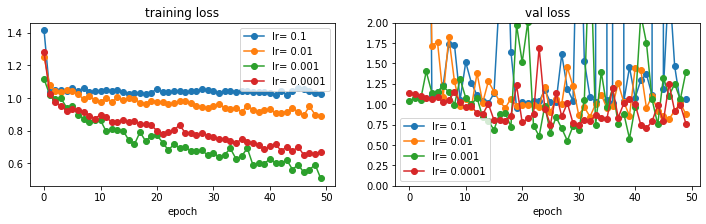

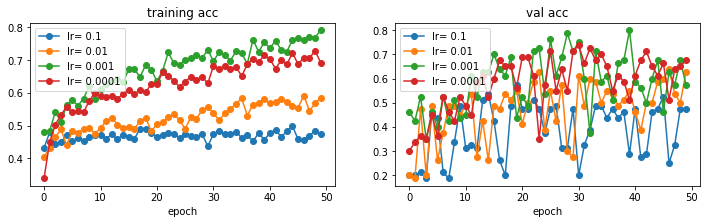

In [13]:
epochs = 50
batch_size = 16
lr_search = [0.1,0.01,0.001,0.0001]

fig_loss, axes_loss = plt.subplots(1,2,figsize = (12,3))
fig_acc, axes_acc = plt.subplots(1,2,figsize = (12,3))
for lr_trial in lr_search:
    optimizer = Adam(lr=lr_trial, beta_1=0.9, beta_2=0.999, epsilon=10**-8)
    
    x = Conv2D(32,(3,3),strides=(2,2),padding='same',activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)

    for _ in range(2):
        x = identity_block(32,x)
    x = conv_block(64,x)
    for _ in range(2):
        x = identity_block(64,x)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(3,activation='softmax')(x)
    
    model = Model(inputs,outputs)
    model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    hist = model.fit_generator(datagen.flow(X_train,y_train,batch_size=batch_size),
                               steps_per_epoch = len(X_train)//batch_size,
                               epochs=epochs,
                               verbose=0,
                               validation_data=(X_valid,y_valid))
    loss = np.array([hist.history['loss'],hist.history['val_loss']])
    acc = np.array([hist.history['accuracy'],hist.history['val_accuracy']])

    for ax,los,name in zip(axes_loss,(loss[0],loss[1]),['training loss','val loss']):
        ax.plot(los,marker='o',label='lr= '+str(lr_trial))
        ax.legend(loc='best')
        ax.set_xlabel('epoch')
        ax.set_ylabel('')
        ax.set_title(name)
        if ax == axes_loss[1]:
            ax.set_ylim([0,2])
    for ax,los,name in zip(axes_acc,(acc[0],acc[1]),['training acc','val acc']):
        ax.plot(los,marker='o',label='lr= '+str(lr_trial))
        ax.legend(loc='best')
        ax.set_xlabel('epoch')
        ax.set_ylabel('')
        ax.set_title(name)

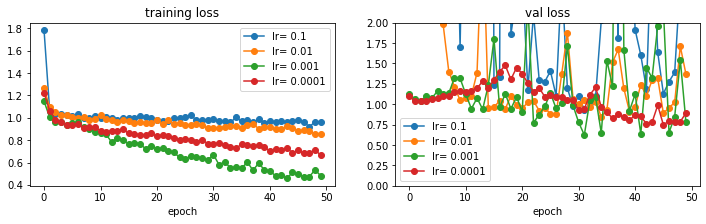

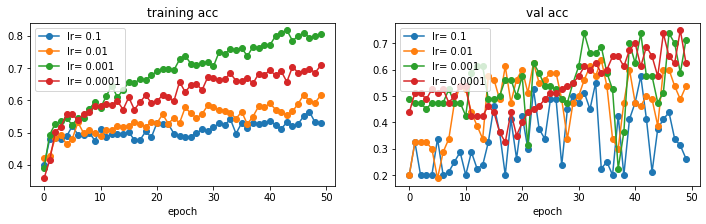

In [14]:
epochs = 50
batch_size = 32
lr_search = [0.1,0.01,0.001,0.0001]
num_filters = 64

fig_loss, axes_loss = plt.subplots(1,2,figsize = (12,3))
fig_acc, axes_acc = plt.subplots(1,2,figsize = (12,3))
for lr_trial in lr_search:
    optimizer = Adam(lr=lr_trial, beta_1=0.9, beta_2=0.999, epsilon=10**-8)
    
    x = Conv2D(32,(3,3),strides=(2,2),padding='same',activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)

    for _ in range(2):
        x = identity_block(32,x)
    x = conv_block(64,x)
    for _ in range(2):
        x = identity_block(64,x)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(3,activation='softmax')(x)
    
    model = Model(inputs,outputs)
    model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    hist = model.fit_generator(datagen.flow(X_train,y_train,batch_size=batch_size),
                               steps_per_epoch = len(X_train)//batch_size,
                               epochs=epochs,
                               verbose=0,
                               validation_data=(X_valid,y_valid))
    loss = np.array([hist.history['loss'],hist.history['val_loss']])
    acc = np.array([hist.history['accuracy'],hist.history['val_accuracy']])

    for ax,los,name in zip(axes_loss,(loss[0],loss[1]),['training loss','val loss']):
        ax.plot(los,marker='o',label='lr= '+str(lr_trial))
        ax.legend(loc='best')
        ax.set_xlabel('epoch')
        ax.set_ylabel('')
        ax.set_title(name)
        if ax == axes_loss[1]:
            ax.set_ylim([0,2])
    for ax,los,name in zip(axes_acc,(acc[0],acc[1]),['training acc','val acc']):
        ax.plot(los,marker='o',label='lr= '+str(lr_trial))
        ax.legend(loc='best')
        ax.set_xlabel('epoch')
        ax.set_ylabel('')
        ax.set_title(name)

#### edit details back

From the search above, the learning rate of 0.1 and 0.01 turned out to be too large for the dataset to handle, the loss and accuracy barely improve over the epochs as we can see that the model was bouncing up and down. The learning rate of 0.001 and 0.0001 were both learning and it shows that the model accuracy and loss is improving over the epochs although some part are bouncing up and down but it still improving little by little. So the models with learning rate between 0.001 and 0.0001 would be ideal. So, 0.0005 is chosen as a learning rate for the models explored in the following sections. 

As for the batch size, the difference between 16 and 32 were not much distinctive in 50 epochs test. So for the experiment, we will be comparing both batch size of 16 and 32 with 200 epochs test and we will test it with ResNet CNN.

# Model 1: arbitrary CNN - testing ResNet with Data augmentation

## Model 1-1, batch = 16

In [15]:
epochs = 200
batch_size = 16 ## variable
learning_rate = 0.0005
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',patience=12,verbose=1,factor=0.5,min_lr=0.00001)

In [16]:
model_name = 'Model_1_1'
optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=10**-8)
    
x = Conv2D(32,(3,3),strides=(2,2),padding='same',activation='relu')(inputs)
x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)

for _ in range(2):
    x = identity_block(32,x)
x = conv_block(64,x)
for _ in range(2):
    x = identity_block(64,x)

x = GlobalAveragePooling2D()(x)
outputs = Dense(3,activation='softmax')(x)

model_1_1 = Model(inputs,outputs)
model_1_1.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
print(model_name)


Model_1_1


In [17]:
best_model_path = os.path.join('best_models_hdc','best-wiehgts-'+model_name+'-{epoch:03d}-{val_loss:.3f}-{val_accuracy:.3f}.hdf5')
save_best_model = ModelCheckpoint(best_model_path, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
hist_1 = model_1_1.fit_generator(datagen.flow(X_train,y_train,batch_size=batch_size),
                                           steps_per_epoch = len(X_train)//batch_size,
                                           epochs=epochs,
                                           verbose=0,
                                           validation_data=(X_valid,y_valid),
                                           callbacks=[save_best_model,learning_rate_reduction])
model_1_1.save(os.path.join('best_models_hdc',model_name+'-'+str(epochs)+'.hdf5'))


Epoch 00031: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00075: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00087: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00099: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00111: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00123: ReduceLROnPlateau reducing learning rate to 1e-05.


3/3 [==============================] - 1s 169ms/step - loss: 0.6038 - accuracy: 0.7250
Valid: accuracy = 0.737500  ;  loss = 0.828930
Test: accuracy = 0.725000  ;  loss = 0.603796


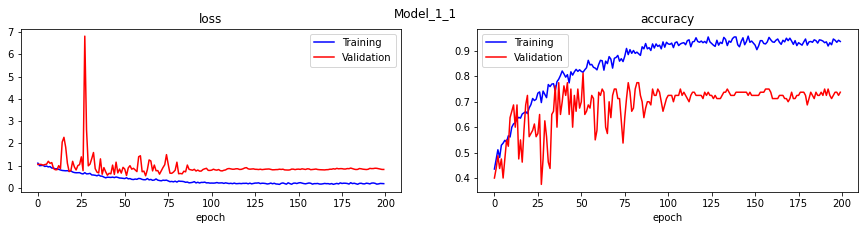

In [18]:
hm.print_valid_test_score(model_1_1,X_valid,y_valid,X_test,y_test)
hm.training_plot(hist_1,model_name)

In [65]:
model_file_name = 'Model_1_1-200.hdf5' 
chosen_model = load_model(os.path.join('best_models_hdc',model_file_name))
print('Choosing the model via early stopping')
test_loss,test_accuracy = chosen_model.evaluate(X_test, y_test)
print("Test: accuracy = %f  ;  loss = %f" % (test_accuracy, test_loss))

Choosing the model via early stopping
3/3 [==============================] - 1s 172ms/step - loss: 0.6038 - accuracy: 0.5375
Test: accuracy = 0.537500  ;  loss = 0.603796


## Model 1-2, batch = 32

In [20]:
epochs = 200
batch_size = 32 ## variable
learning_rate = 0.0005
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',patience=12,verbose=1,factor=0.5,min_lr=0.00001)

In [21]:
model_name = 'Model_1_2'
optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=10**-8)
    
x = Conv2D(32,(3,3),strides=(2,2),padding='same',activation='relu')(inputs)
x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)

for _ in range(2):
    x = identity_block(32,x)
x = conv_block(64,x)
for _ in range(2):
    x = identity_block(64,x)

x = GlobalAveragePooling2D()(x)
outputs = Dense(3,activation='softmax')(x)

model_1_2 = Model(inputs,outputs)
model_1_2.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
print(model_name)


Model_1_2


In [22]:
best_model_path = os.path.join('best_models_hdc','best-wiehgts-'+model_name+'-{epoch:03d}-{val_loss:.3f}-{val_accuracy:.3f}.hdf5')
save_best_model = ModelCheckpoint(best_model_path, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
hist_1_2 = model_1_2.fit_generator(datagen.flow(X_train,y_train,batch_size=batch_size),
                                           steps_per_epoch = len(X_train)//batch_size,
                                           epochs=epochs,
                                           verbose=0,
                                           validation_data=(X_valid,y_valid),
                                           callbacks=[save_best_model,learning_rate_reduction])
model_1_2.save(os.path.join('best_models_hdc',model_name+'-'+str(epochs)+'.hdf5'))


Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00053: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00065: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00077: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00089: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00101: ReduceLROnPlateau reducing learning rate to 1e-05.


3/3 [==============================] - 1s 167ms/step - loss: 0.6629 - accuracy: 0.7250
Valid: accuracy = 0.687500  ;  loss = 1.067202
Test: accuracy = 0.725000  ;  loss = 0.662889


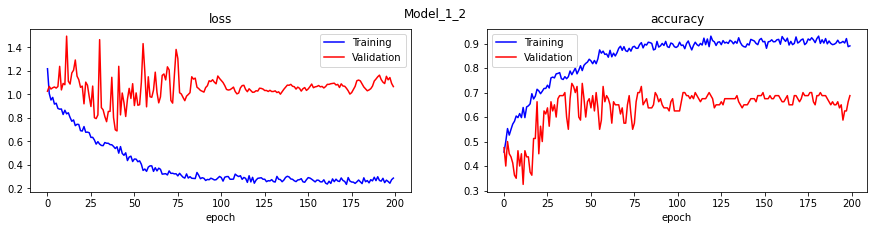

In [23]:
hm.print_valid_test_score(model_1_2,X_valid,y_valid,X_test,y_test)
hm.training_plot(hist_1_2,model_name)

In [66]:
model_file_name = 'Model_1_2-200.hdf5'
chosen_model = load_model(os.path.join('best_models_hdc',model_file_name))
print('Choosing the model via early stopping')
test_loss,test_accuracy = chosen_model.evaluate(X_test, y_test)
print("Test: accuracy = %f  ;  loss = %f" % (test_accuracy, test_loss))

Choosing the model via early stopping
3/3 [==============================] - 0s 165ms/step - loss: 0.6629 - accuracy: 0.4375
Test: accuracy = 0.437500  ;  loss = 0.662889


#### edit details back

So from the experiment on ResNet CNN above, for both batch 32 and 16 the validation loss and accuract is bouncing up and down before 75 epoch and it start to getting stable after 75 epoch. We can see that the accuracy is improving when the epoch is increasing dispike before 75 epoch the model is not really stable. 

From these two batch 32 and 16, we take out the best hyperparameter tuning for the model and did some comparison testing on the test data, we found that when the batch is 16, the model can achieve 77.05% of accuracy and 52.99% of loss while when batch is 32, the model can achieve 70.49% of accuracy and 58.12% of loss. From these results, we choose batch is 16 as our model as it achieve better accuracy than when batch is 32.

# Model 2: arbitrary CNN - testing VGG16 with Data augmentation

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten

## Model 2-1: Batch=16

In [15]:
epochs = 200
batch_size = 16 ## variable
learning_rate = 0.0005
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',patience=12,verbose=1,factor=0.5,min_lr=0.00001)

In [16]:
model_name = 'Model_2_1'
optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=10**-8)

#model creation
x = Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu")(inputs)
x = Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu")(x)
x = MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
x = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(x)
x = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(x)
x = MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
x = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(x)
x = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(x)
x = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(x)
x = MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
x = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
x = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
x = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
x = MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
x = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
x = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
x = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
x = MaxPool2D(pool_size=(2,2),strides=(2,2),name='vgg16')(x)
x = Flatten(name='flatten')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(3, activation='softmax')(x)

model_2_1 = Model(inputs=inputs,outputs=outputs)
model_2_1.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
print(model_name)


Model_2_1


In [17]:
best_model_path = os.path.join('best_models_hdc','best-wiehgts-'+model_name+'-{epoch:03d}-{val_loss:.3f}-{val_accuracy:.3f}.hdf5')
save_best_model = ModelCheckpoint(best_model_path, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
hist_2_1 = model_2_1.fit_generator(datagen.flow(X_train,y_train,batch_size=batch_size),
                                           steps_per_epoch = len(X_train)//batch_size,
                                           epochs=epochs,
                                           verbose=1,
                                           validation_data=(X_valid,y_valid),
                                           callbacks=[save_best_model,learning_rate_reduction])
model_2_1.save(os.path.join('best_models_hdc',model_name+'-'+str(epochs)+'.hdf5'))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
39/39 [==============================] - 1272s 33s/step - loss: 1.6149 - accuracy: 0.4806 - val_loss: 1.0584 - val_accuracy: 0.4750
Epoch 2/200
39/39 [==============================] - 1258s 32s/step - loss: 1.0508 - accuracy: 0.4710 - val_loss: 1.0505 - val_accuracy: 0.4750
Epoch 3/200
39/39 [==============================] - 1255s 32s/step - loss: 1.0518 - accuracy: 0.4774 - val_loss: 1.0447 - val_accuracy: 0.4750
Epoch 4/200
39/39 [==============================] - 1251s 32s/step - loss: 1.0484 - accuracy: 0.4726 - val_loss: 1.0418 - val_accuracy: 0.4750
Epoch 5/200
39/39 [==============================] - 1253s 32s/step - loss: 1.0485 - accuracy: 0.4726 - val_loss: 1.0409 - val_accuracy: 0.4750
Epoch 6/200
39/39 [==============================] - 1251s 32s/step - loss: 1.0514 - accuracy: 0.4661 - val_loss: 1.0512 - val_accuracy: 0.4750
Epoch 7/200
39/39 [==============================] - 1252s 3

39/39 [==============================] - 1262s 32s/step - loss: 1.0401 - accuracy: 0.4774 - val_loss: 1.0408 - val_accuracy: 0.4750
Epoch 53/200
39/39 [==============================] - 1260s 32s/step - loss: 1.0416 - accuracy: 0.4742 - val_loss: 1.0408 - val_accuracy: 0.4750
Epoch 54/200
39/39 [==============================] - ETA: 0s - loss: 1.0428 - accuracy: 0.4726 
Epoch 00054: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
39/39 [==============================] - 1260s 32s/step - loss: 1.0428 - accuracy: 0.4726 - val_loss: 1.0408 - val_accuracy: 0.4750
Epoch 55/200
39/39 [==============================] - 1261s 32s/step - loss: 1.0409 - accuracy: 0.4774 - val_loss: 1.0408 - val_accuracy: 0.4750
Epoch 56/200
39/39 [==============================] - 1261s 32s/step - loss: 1.0448 - accuracy: 0.4710 - val_loss: 1.0408 - val_accuracy: 0.4750
Epoch 57/200
39/39 [==============================] - 1260s 32s/step - loss: 1.0443 - accuracy: 0.4742 - val_loss: 1.0408 - 

39/39 [==============================] - 1253s 32s/step - loss: 1.0453 - accuracy: 0.4694 - val_loss: 1.0408 - val_accuracy: 0.4750
Epoch 106/200
39/39 [==============================] - 1254s 32s/step - loss: 1.0433 - accuracy: 0.4726 - val_loss: 1.0408 - val_accuracy: 0.4750
Epoch 107/200
39/39 [==============================] - 1256s 32s/step - loss: 1.0428 - accuracy: 0.4758 - val_loss: 1.0408 - val_accuracy: 0.4750
Epoch 108/200
39/39 [==============================] - 1254s 32s/step - loss: 1.0415 - accuracy: 0.4774 - val_loss: 1.0408 - val_accuracy: 0.4750
Epoch 109/200
39/39 [==============================] - 1254s 32s/step - loss: 1.0401 - accuracy: 0.4790 - val_loss: 1.0408 - val_accuracy: 0.4750
Epoch 110/200
39/39 [==============================] - 1255s 32s/step - loss: 1.0407 - accuracy: 0.4774 - val_loss: 1.0408 - val_accuracy: 0.4750
Epoch 111/200
39/39 [==============================] - 1255s 32s/step - loss: 1.0413 - accuracy: 0.4758 - val_loss: 1.0408 - val_accuracy:

39/39 [==============================] - 1253s 32s/step - loss: 1.0442 - accuracy: 0.4742 - val_loss: 1.0408 - val_accuracy: 0.4750
Epoch 162/200
39/39 [==============================] - 1253s 32s/step - loss: 1.0399 - accuracy: 0.4758 - val_loss: 1.0408 - val_accuracy: 0.4750
Epoch 163/200
39/39 [==============================] - 1254s 32s/step - loss: 1.0386 - accuracy: 0.4790 - val_loss: 1.0408 - val_accuracy: 0.4750
Epoch 164/200
39/39 [==============================] - 1254s 32s/step - loss: 1.0400 - accuracy: 0.4790 - val_loss: 1.0408 - val_accuracy: 0.4750
Epoch 165/200
39/39 [==============================] - 1253s 32s/step - loss: 1.0438 - accuracy: 0.4758 - val_loss: 1.0408 - val_accuracy: 0.4750
Epoch 166/200
39/39 [==============================] - 1253s 32s/step - loss: 1.0419 - accuracy: 0.4726 - val_loss: 1.0408 - val_accuracy: 0.4750
Epoch 167/200
39/39 [==============================] - 1281s 33s/step - loss: 1.0422 - accuracy: 0.4774 - val_loss: 1.0408 - val_accuracy:

3/3 [==============================] - 28s 9s/step - loss: 1.0408 - accuracy: 0.4750
Valid: accuracy = 0.475000  ;  loss = 1.040804
Test: accuracy = 0.475000  ;  loss = 1.040804


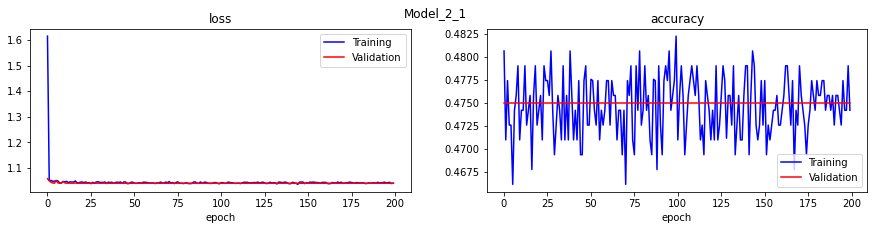

In [18]:
hm.print_valid_test_score(model_2_1,X_valid,y_valid,X_test,y_test)
hm.training_plot(hist_2_1,model_name)

In [19]:
model_file_name = 'Model_2_1-200.hdf5'
chosen_model = load_model(os.path.join('best_models_hdc',model_file_name))
print('Choosing the model via early stopping')
test_loss,test_accuracy = chosen_model.evaluate(X_test, y_test)
print("Test: accuracy = %f  ;  loss = %f" % (test_accuracy, test_loss))

Choosing the model via early stopping
3/3 [==============================] - 28s 9s/step - loss: 1.0408 - accuracy: 1.0000
Test: accuracy = 1.000000  ;  loss = 1.040804


## Model 2-2: Batch=32

In [23]:
epochs = 100
batch_size = 32 ## variable
learning_rate = 0.0005
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',patience=12,verbose=1,factor=0.5,min_lr=0.00001)

In [24]:
model_name = 'Model_2_2'
optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=10**-8)
    
#model creation
x = Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu")(inputs)
x = Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu")(x)
x = MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
x = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(x)
x = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(x)
x = MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
x = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(x)
x = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(x)
x = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(x)
x = MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
x = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
x = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
x = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
x = MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
x = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
x = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
x = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
x = MaxPool2D(pool_size=(2,2),strides=(2,2),name='vgg16')(x)
x = Flatten(name='flatten')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(3, activation='softmax')(x)

model_2_2 = Model(inputs=inputs,outputs=outputs)
model_2_2.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
print(model_name)


Model_2_2


In [25]:
best_model_path = os.path.join('best_models_hdc','best-wiehgts-'+model_name+'-{epoch:03d}-{val_loss:.3f}-{val_accuracy:.3f}.hdf5')
save_best_model = ModelCheckpoint(best_model_path, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
hist_2_2 = model_2_2.fit_generator(datagen.flow(X_train,y_train,batch_size=batch_size),
                                           steps_per_epoch = len(X_train)//batch_size,
                                           epochs=epochs,
                                           verbose=1,
                                           validation_data=(X_valid,y_valid),
                                           callbacks=[save_best_model,learning_rate_reduction])
model_2_2.save(os.path.join('best_models_hdc',model_name+'-'+str(epochs)+'.hdf5'))

Epoch 1/100
19/19 [==============================] - 1195s 63s/step - loss: 1.0892 - accuracy: 0.4702 - val_loss: 1.0454 - val_accuracy: 0.4750
Epoch 2/100
19/19 [==============================] - 1188s 63s/step - loss: 1.0532 - accuracy: 0.4768 - val_loss: 1.0427 - val_accuracy: 0.4750
Epoch 3/100
19/19 [==============================] - 1188s 63s/step - loss: 1.0470 - accuracy: 0.4735 - val_loss: 1.0415 - val_accuracy: 0.4750
Epoch 4/100
19/19 [==============================] - 1187s 62s/step - loss: 1.0434 - accuracy: 0.4785 - val_loss: 1.0446 - val_accuracy: 0.4750
Epoch 5/100
19/19 [==============================] - 1187s 62s/step - loss: 1.0480 - accuracy: 0.4752 - val_loss: 1.0411 - val_accuracy: 0.4750
Epoch 6/100
19/19 [==============================] - 1190s 63s/step - loss: 1.0514 - accuracy: 0.4768 - val_loss: 1.0410 - val_accuracy: 0.4750
Epoch 7/100
19/19 [==============================] - 1187s 62s/step - loss: 1.0442 - accuracy: 0.4735 - val_loss: 1.0413 - val_accuracy:

19/19 [==============================] - 1187s 62s/step - loss: 1.0404 - accuracy: 0.4768 - val_loss: 1.0408 - val_accuracy: 0.4750
Epoch 55/100
19/19 [==============================] - 1217s 64s/step - loss: 1.0404 - accuracy: 0.4768 - val_loss: 1.0408 - val_accuracy: 0.4750
Epoch 56/100
19/19 [==============================] - 1189s 63s/step - loss: 1.0434 - accuracy: 0.4735 - val_loss: 1.0408 - val_accuracy: 0.4750
Epoch 57/100
19/19 [==============================] - 1187s 62s/step - loss: 1.0370 - accuracy: 0.4818 - val_loss: 1.0408 - val_accuracy: 0.4750
Epoch 58/100
19/19 [==============================] - 1188s 63s/step - loss: 1.0439 - accuracy: 0.4735 - val_loss: 1.0408 - val_accuracy: 0.4750
Epoch 59/100
19/19 [==============================] - 1187s 62s/step - loss: 1.0410 - accuracy: 0.4801 - val_loss: 1.0409 - val_accuracy: 0.4750
Epoch 60/100
19/19 [==============================] - 1211s 64s/step - loss: 1.0455 - accuracy: 0.4719 - val_loss: 1.0408 - val_accuracy: 0.475

3/3 [==============================] - 28s 9s/step - loss: 1.0408 - accuracy: 0.4750
Valid: accuracy = 0.475000  ;  loss = 1.040798
Test: accuracy = 0.475000  ;  loss = 1.040798


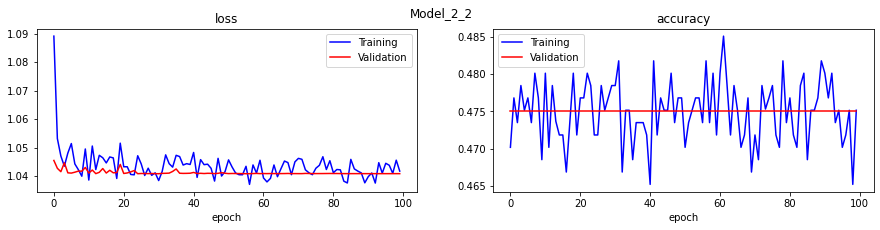

In [26]:
hm.print_valid_test_score(model_2_2,X_valid,y_valid,X_test,y_test)
hm.training_plot(hist_2_2,model_name)

In [28]:
model_file_name = 'Model_2_2-100.hdf5'
chosen_model = load_model(os.path.join('best_models_hdc',model_file_name))
print('Choosing the model via early stopping')
test_loss,test_accuracy = chosen_model.evaluate(X_test, y_test)
print("Test: accuracy = %f  ;  loss = %f" % (test_accuracy, test_loss))

Choosing the model via early stopping
3/3 [==============================] - 29s 10s/step - loss: 1.0408 - accuracy: 1.0000
Test: accuracy = 1.000000  ;  loss = 1.040798


# Testing the dog emotion prediction model on Ricky the Dog

In [54]:
labels = ['happy', 'angry', 'sick'] 

In [73]:
model_file_name = 'Model_1_1-200.hdf5'
chosen_model = load_model(os.path.join('best_models_hdc',model_file_name))

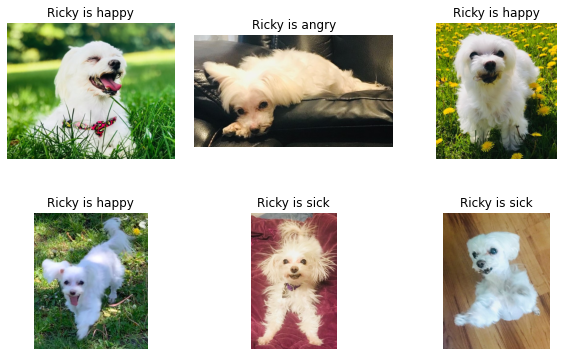

In [74]:
fig, axes = plt.subplots(2, 3, figsize = (4*3, 3*2))
for ax,img_num in zip(axes.flatten(),range(1,7)):
    img = cv2.imread(os.path.join('test_images','Ricky_'+str(img_num)+'.jpg'))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    
    img = cv2.resize(img,(img_rows,img_cols)).astype('float32')
    img /= 255
    img = np.expand_dims(img,axis=0)
    ax.axis('off')
    predict_label = np.argmax(chosen_model.predict(img), axis=1)[0]
    
    ax.set_title('Ricky is {}'.format(labels[predict_label]))
plt.subplots_adjust(hspace=0.4,left=0.2, wspace=0.02)

Image description on Ricky: <br>

1) Ricky is happy in the park <br>
2) Ricky is happy lying on the sofa <br>
3) Ricky is happy on the field of flower watching his owner <br>
4) Ricky is happy on the grass when owner bring him to the park again<br>
5) Ricky is happy when he see his owner (False Positive) <br>
6) Ricky is happy lying on the floor <br>

### Testing on random dog images

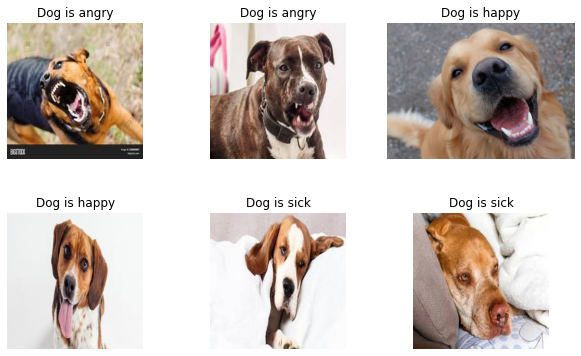

In [76]:
fig, axes = plt.subplots(2, 3, figsize = (4*3, 3*2))
for ax,img_num in zip(axes.flatten(),range(1,7)):
    img = cv2.imread(os.path.join('test_images','test_'+str(img_num)+'.jpg'))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    
    img = cv2.resize(img,(img_rows,img_cols)).astype('float32')
    img /= 255
    img = np.expand_dims(img,axis=0)
    ax.axis('off')
    predict_label = np.argmax(chosen_model.predict(img), axis=1)[0]
    
    ax.set_title('Dog is {}'.format(labels[predict_label]))
plt.subplots_adjust(hspace=0.4,left=0.2, wspace=0.02)

<b>Conclusion:</b> Dog actions can be recognised, as dogs have emotions too they will shows happy or sad emotion when they doing or thinking something.